In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.fft import rfft, rfftfreq, irfft  #fft, fftfreq, 

In [2]:
%matplotlib inline

In [3]:
# minimal 1 minute
def check_streak(minute):
    names = ['timestamp', 'open', 'high', 'low', 'close','volume', 'trade']
    df = pd.read_csv(f'./data/XBTUSD_{minute}.csv', names=names)

    df['norm'] = df.timestamp.diff(1).div(60*minute)
    df['one'] = np.where(df.norm==1.0, 1, 0)
    df['start_of_streak'] = df.one.ne(df.one.shift())
    df['cumsum'] = df['start_of_streak'].cumsum()
    df['streak_counter']= df.groupby('cumsum').cumcount() + 1
    
    max_streak = df.streak_counter.max()
    idx_end = df.streak_counter.idxmax()
    idx_start = idx_end - max_streak + 1
    
    new_df = df.loc[idx_start:idx_end, names]
    new_df['timestamp'] = pd.to_datetime(df['timestamp'],unit='s')
    new_df = new_df.reset_index(drop=True)
    return new_df

In [4]:
def build_feature(df):
    df['return'] = df.close.pct_change()
    df['MA5'] = df['return'].rolling(5).mean()
    df['MA10'] = df['return'].rolling(10).mean()
    df['MA20'] = df['return'].rolling(20).mean()
    df = df.dropna()
    return df

In [5]:
minutes = [1, 5, 15, 60, 720, 1440]
all_df = []
for minute in minutes:
    df = check_streak(minute)
    df = build_feature(df)
    all_df.append(df)

In [6]:
len(all_df)

6

In [7]:
start = [df.timestamp.iloc[0] for df in all_df]
start

[Timestamp('2021-01-11 14:20:00'),
 Timestamp('2020-02-23 02:25:00'),
 Timestamp('2019-12-07 22:00:00'),
 Timestamp('2019-07-15 22:00:00'),
 Timestamp('2018-01-23 00:00:00'),
 Timestamp('2015-01-16 00:00:00')]

In [8]:
end = [df.timestamp.iloc[-1] for df in all_df]
end

[Timestamp('2021-01-17 04:17:00'),
 Timestamp('2020-04-26 05:45:00'),
 Timestamp('2020-07-22 23:30:00'),
 Timestamp('2020-10-24 16:00:00'),
 Timestamp('2022-06-30 12:00:00'),
 Timestamp('2022-06-30 00:00:00')]

In [9]:
delta = [(x-y)//float(i) for (x, y, i) in zip(end, start, minutes)]
# delta

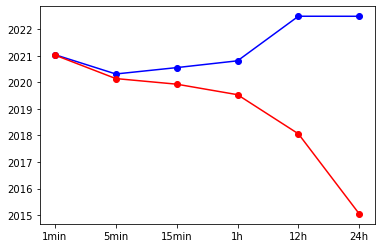

In [10]:
label = ['1min', '5min', '15min', '1h', '12h', '24h']
plt.plot(label, end, c='b', marker='o')
plt.plot(label, start, c='r', marker='o')

In [11]:
def choose_range(start_idx, minutes, all_df, start, end):
    #[1, 5, 15, 60, 720, 1440]
    select_df = all_df[start_idx:]
    select_minutes = minutes[start_idx:]
    sample_rates = [1440//x for x in select_minutes]
    time_idx = [(df[df.timestamp.gt(start[start_idx])].index[0], 
                 df[df.timestamp.lt(end[start_idx])].index[-1]) 
                for df in select_df]
#     print(time_idx)
    select_df = [df.iloc[s:e] for df, (s, e) in zip(select_df, time_idx)]
    return select_minutes, select_df, sample_rates

In [12]:
def plot_x_fx(x='return'):

    for idx in range(1, 5):
        select_minutes, select_df, sample_rates = choose_range(idx, minutes, all_df, start, end)

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))
        for i, (df, sample_rate) in enumerate(zip(select_df, sample_rates)):
            ax[0].plot(df.timestamp, df[x], label=f'{select_minutes[i]}min')
            ax[0].set_title(f'Time domain {idx}')
            ax[0].legend()

            yf = rfft(df[x].values)
            xf = rfftfreq(len(df), 1 / sample_rate)
            amp = np.abs(yf)

            ax[1].plot(xf, amp, label=f'{select_minutes[i]}min')
            ax[1].set_title(f'Freq domain {idx}')
            ax[1].legend()
        plt.tight_layout()
        plt.savefig(f'{idx}_{x}.jpg')  

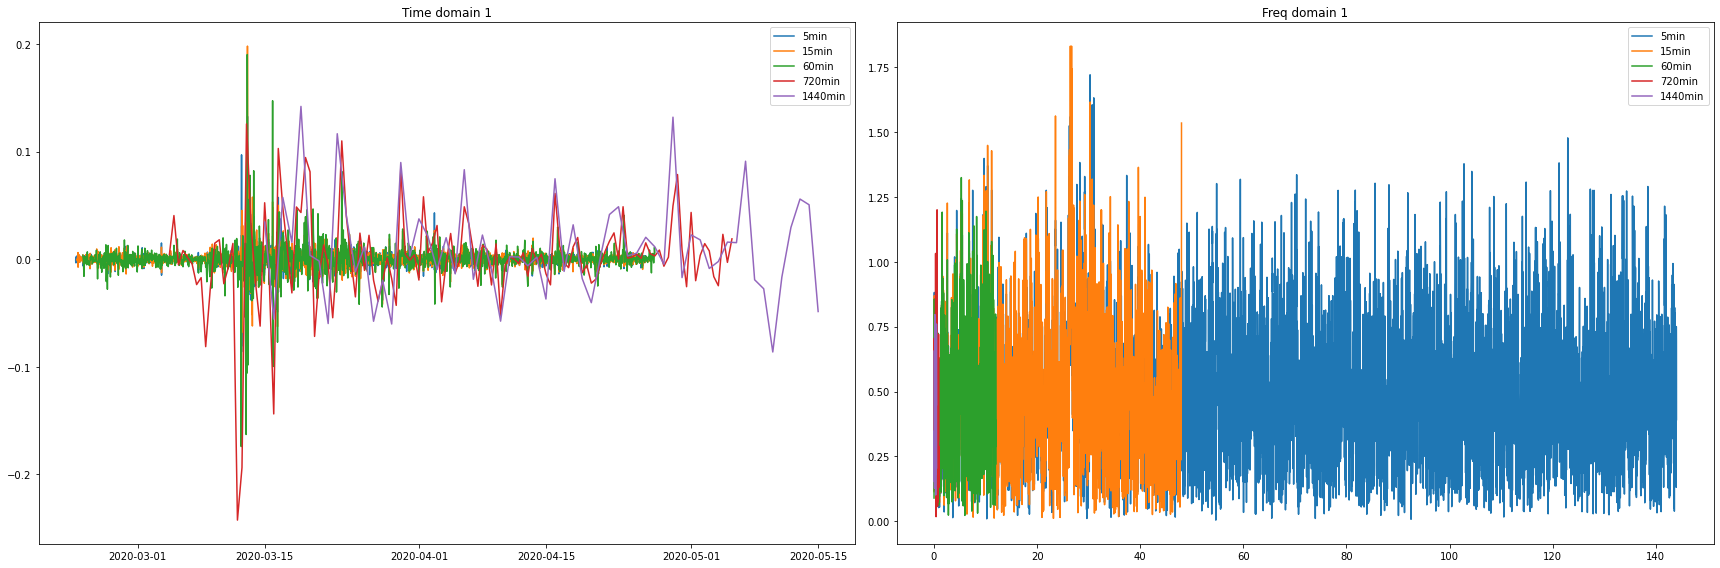

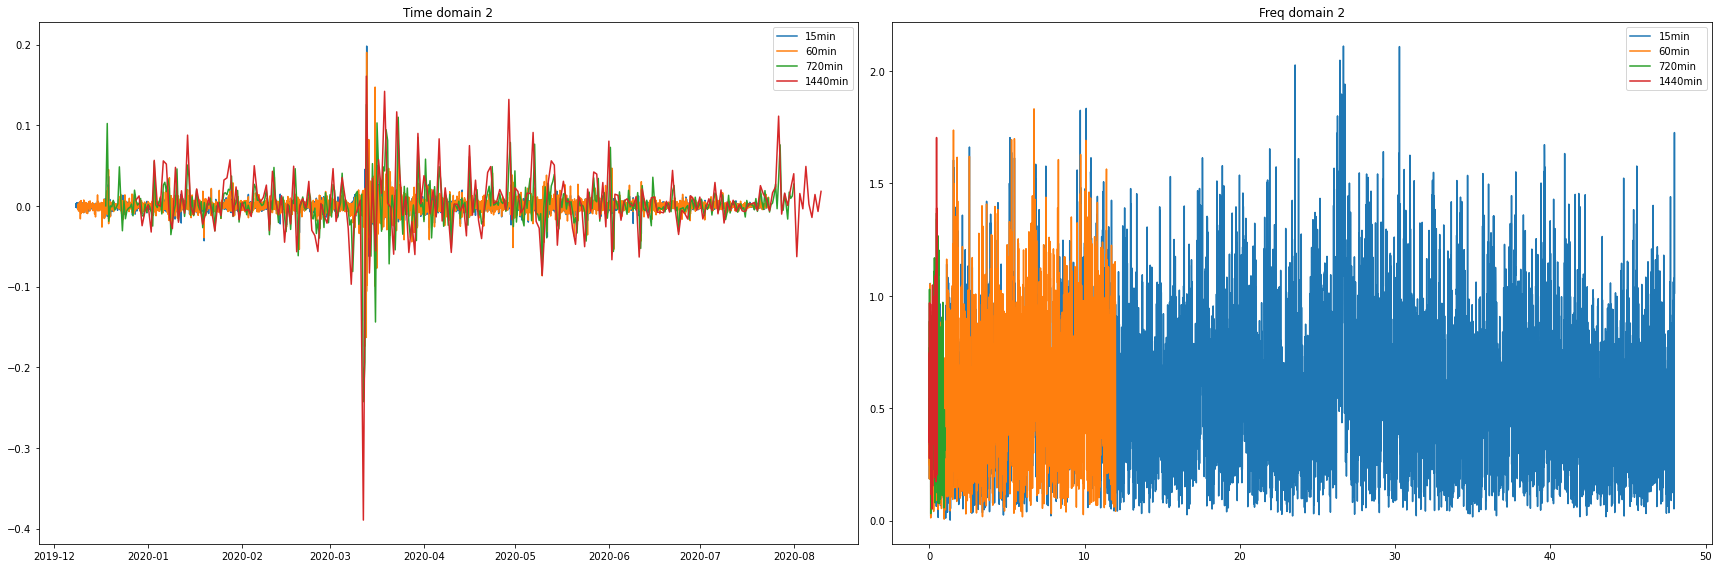

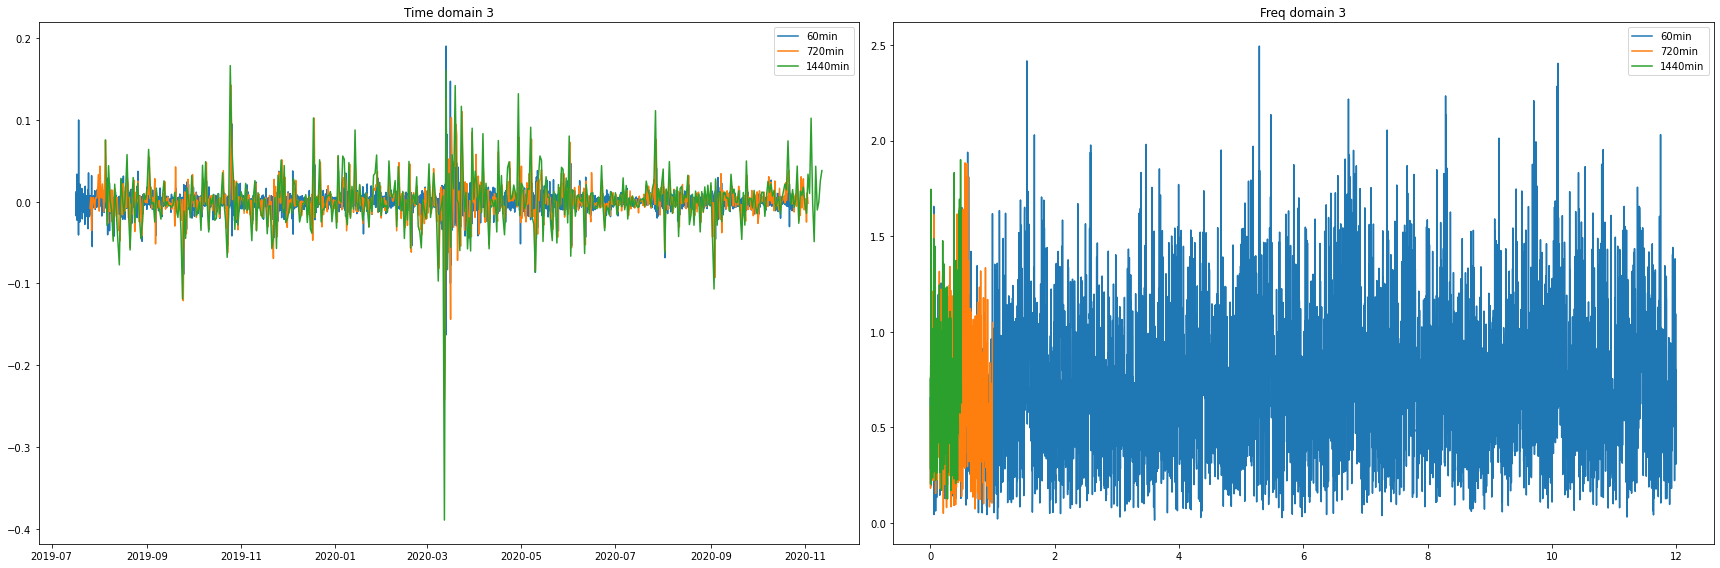

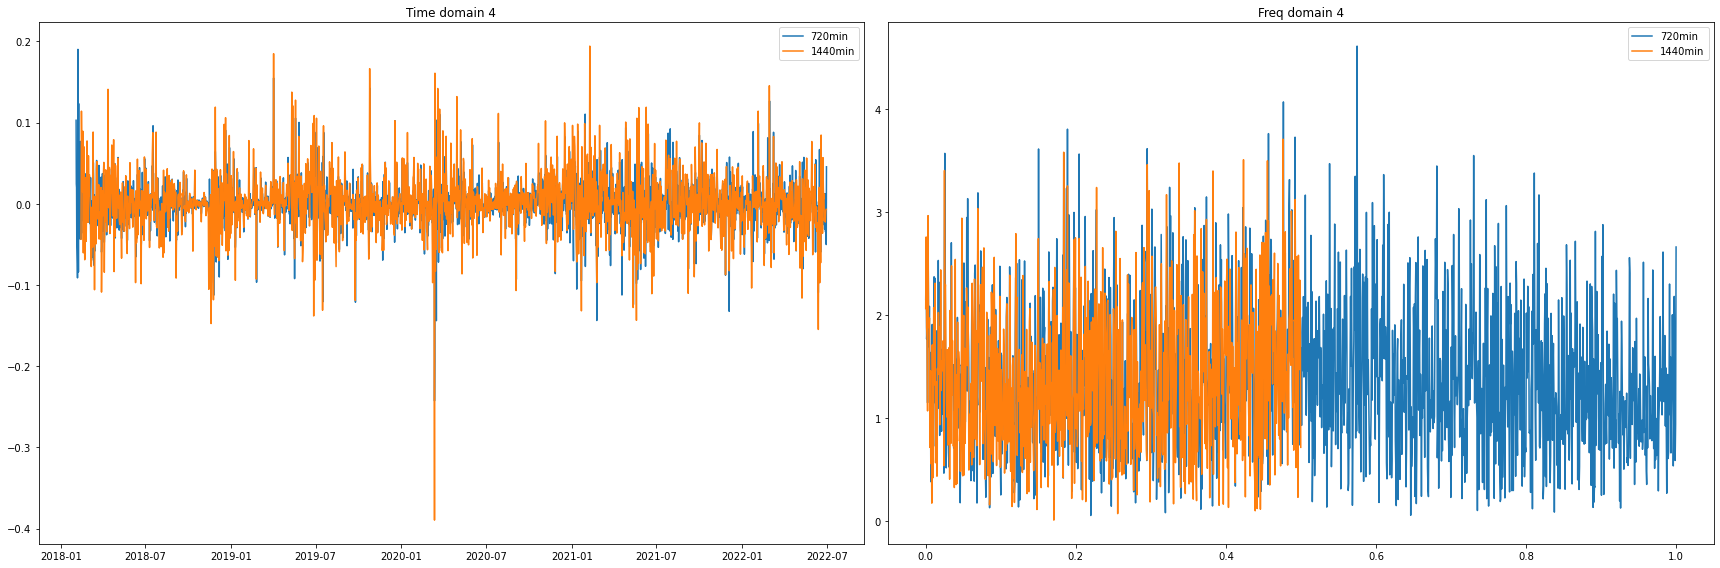

In [13]:
plot_x_fx(x='return')

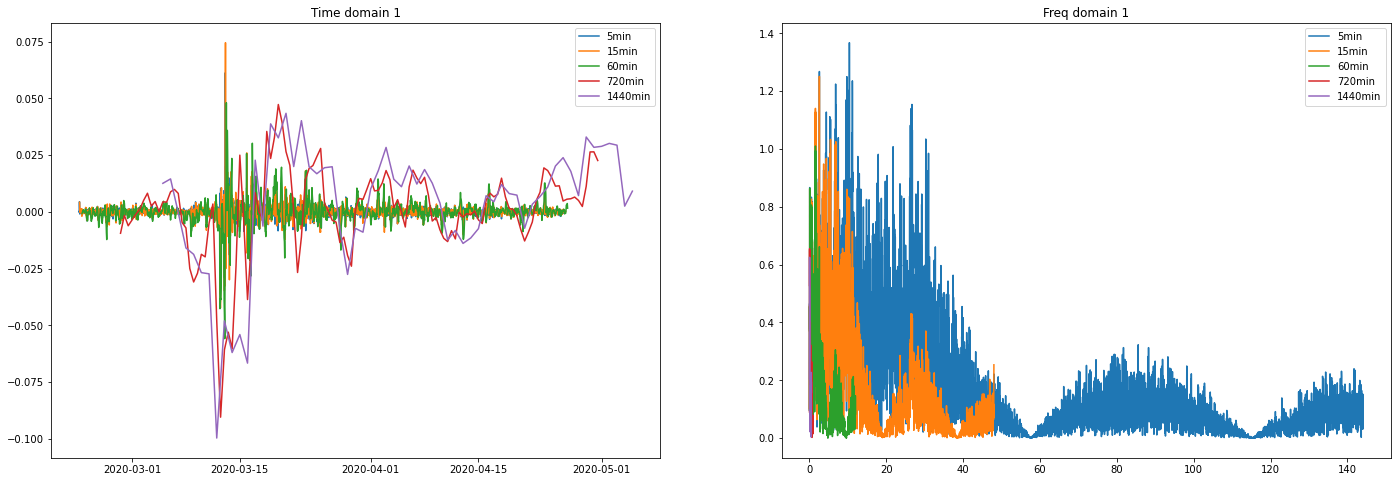

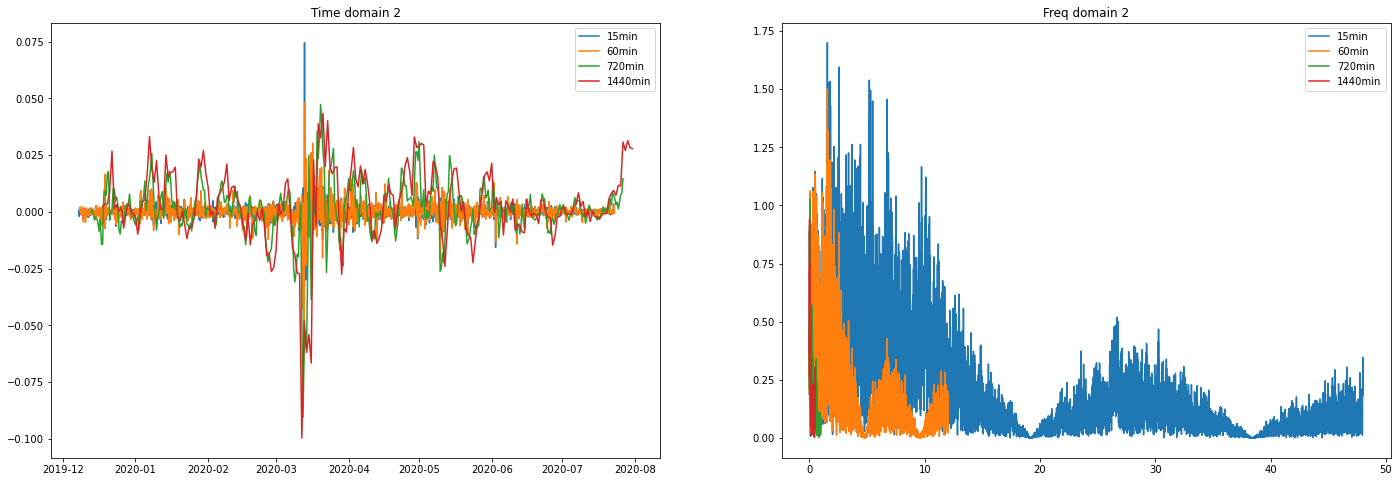

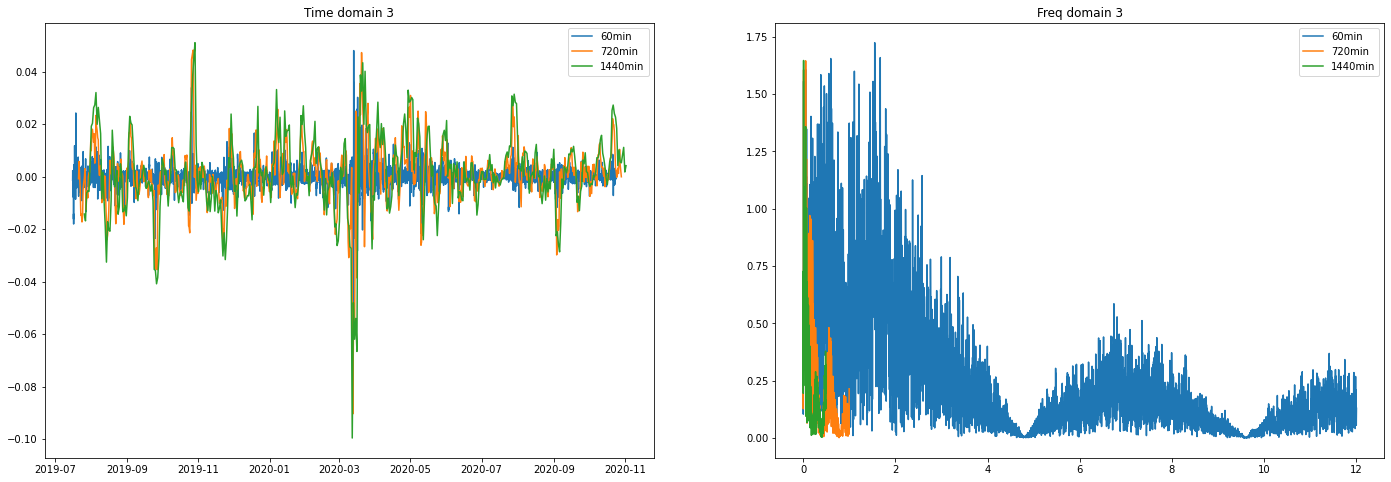

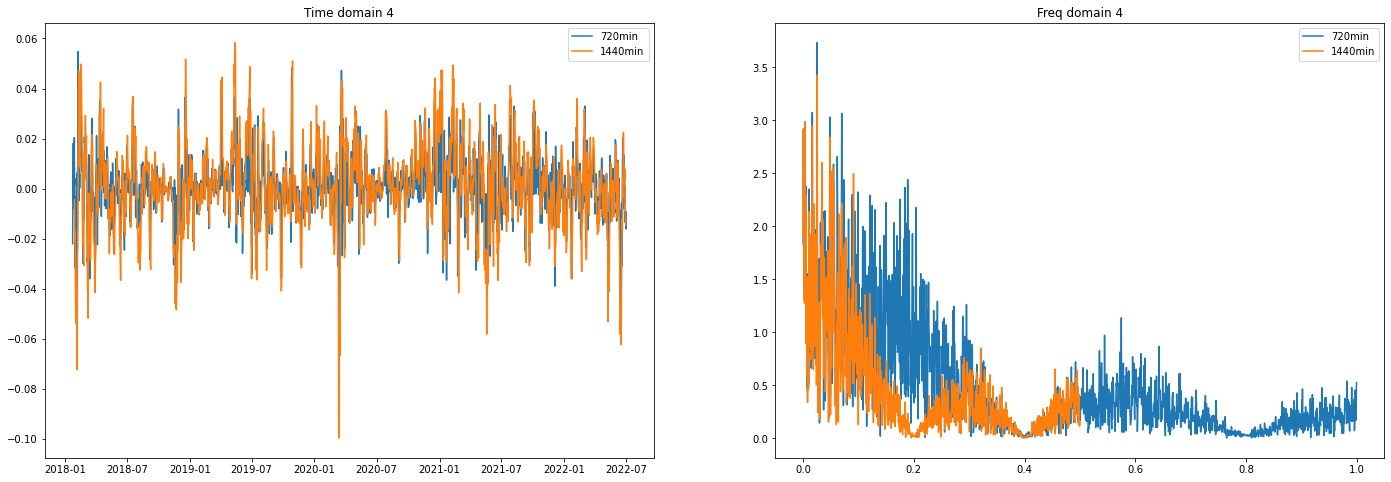

In [30]:
plot_x_fx('MA5')

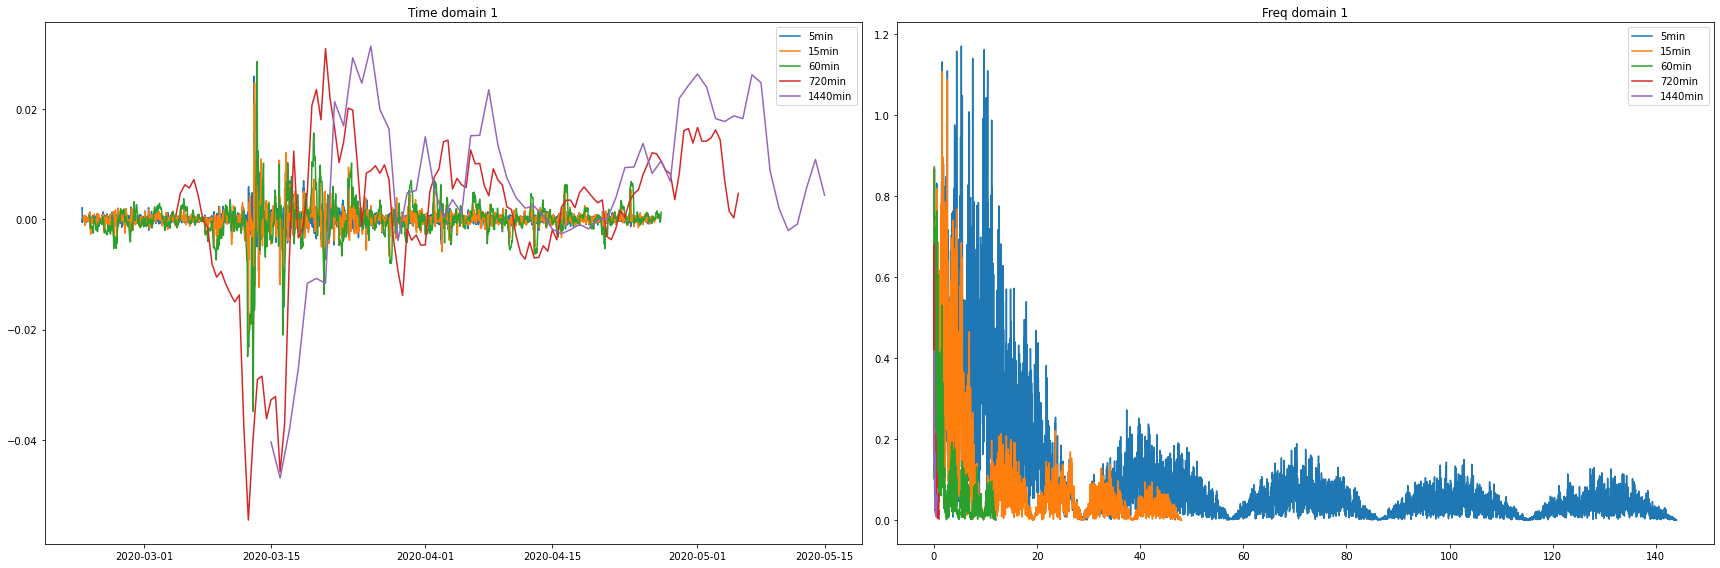

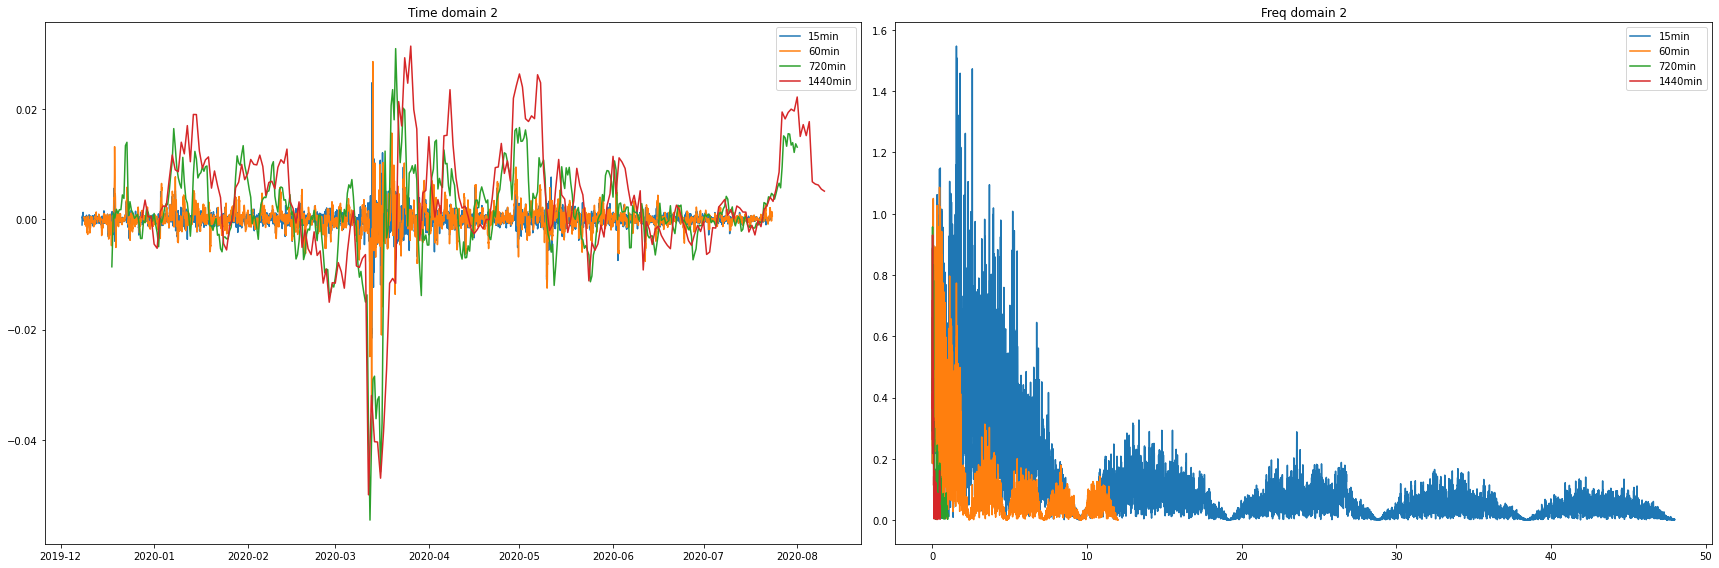

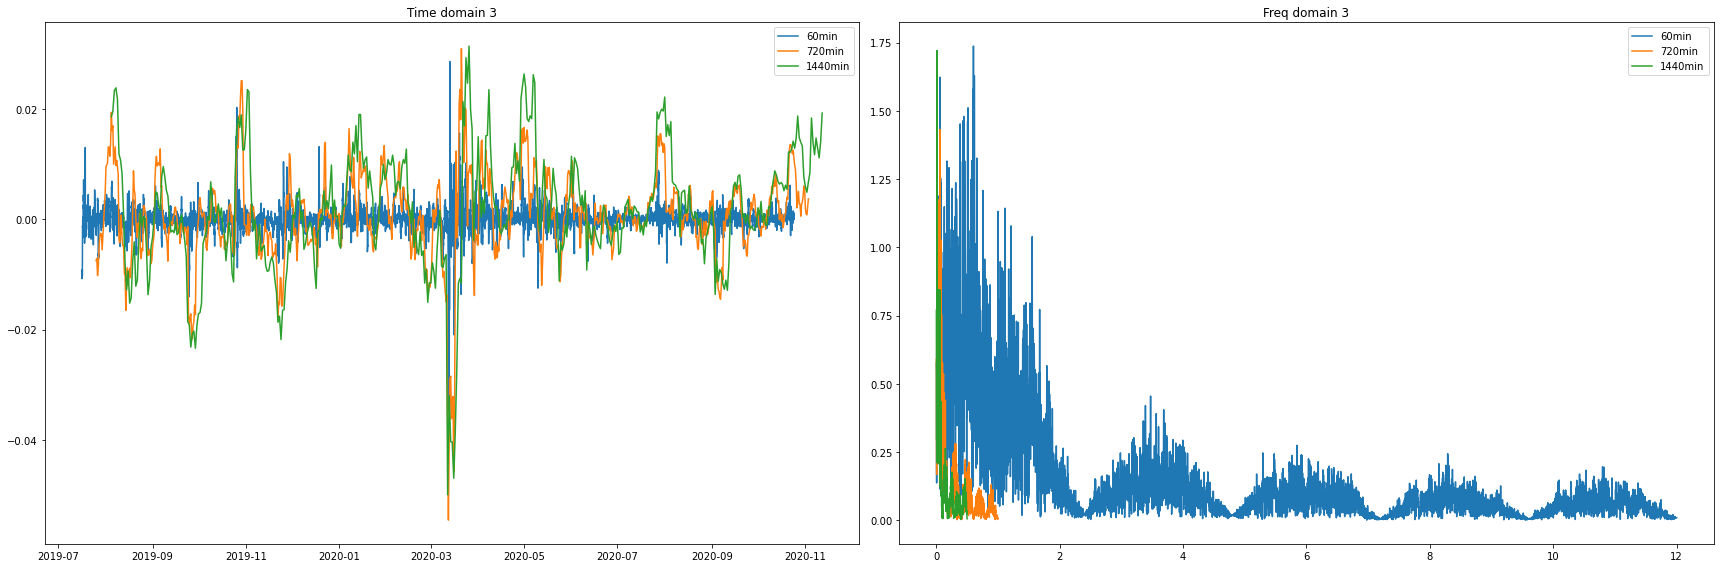

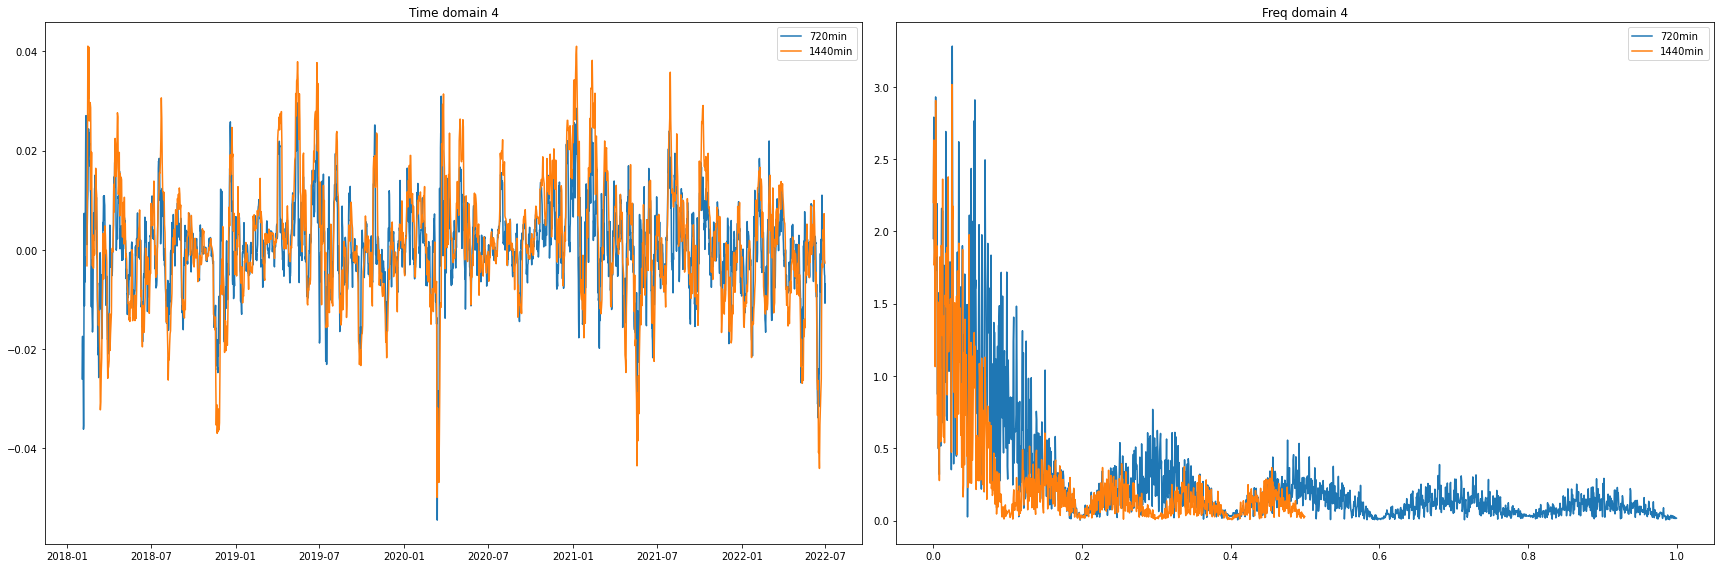

In [14]:
plot_x_fx('MA10')